In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple

# Ensure 'src' is on Python path
PROJECT_ROOT = Path.cwd()  # assuming notebook is run from project root
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from hrv_epatch.dataset.loader import iter_recordings
from hrv_epatch.dataset.naming import parse_recording_key
from hrv_epatch.dataset.annotations import find_annotation_file, load_annotations
from hrv_epatch.dataset.seizures import SeizureEvent, build_seizure_events_from_df
from hrv_epatch.plots.seizure_gantt import plot_recording_seizure_timeline_multiday_clocklabels


In [9]:
TDMS_ROOT = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data")
ANN_ROOT = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed")

recordings = []

for sig, meta, ann in iter_recordings(TDMS_ROOT, ANN_ROOT):
    # if "_iter_count" not in globals():
    #     _iter_count = 0
    # _iter_count += 1
    # if _iter_count > 3:
    #     break

    rec_start = pd.to_datetime(meta.start_time)
    rec_duration_s = len(sig) / meta.fs
    rec_end = rec_start + pd.to_timedelta(rec_duration_s, unit="s")

    tdms_path = Path(meta.path)
    key = parse_recording_key(tdms_path)

    # events direkte fra den rensede annoteringsmappe
    events = build_seizure_events_from_df(ann, rec_start, rec_end)

    recordings.append({
        "patient_id": key.patient_id,
        "enrollment_id": key.enrollment_id,
        "recording_id": key.recording_id,
        "recording_start": rec_start,
        "rec_duration_s": rec_duration_s,
        "rec_end": rec_end,          # lille ekstra felt til debugging
        "seizure_events": events,
        "ann_df": ann,               # gem rå annotationer til debug
        "tdms_name": tdms_path.name,
    })

In [12]:
def plot_recording_seizure_timeline_multiday_clocklabels(
    recordings,
    max_hours: float = 96.0,
    day_grid: bool = True,
    figsize=(24, 14),
    min_box_width_min: float = 5.0,
):
    """
    X-akse: 0–max_hours timer (kan være >24) — tick labels shows clock (hh:mm).
    Each recording is placed relative to its own "day 0" (midnight on the recording date),
    so the clock time is preserved for each recording.

    recordings: list of dicts with keys:
        - patient_id
        - enrollment_id
        - recording_id
        - recording_start (pd.Timestamp)
        - rec_duration_s (float)
        - seizure_events (liste af SeizureEvent)
    """

    fig, ax = plt.subplots(figsize=figsize)

    # Y-labels: én per recording
    labels = []
    for r in recordings:
        pid = r["patient_id"]
        enroll = r["enrollment_id"]
        rec_id = r["recording_id"]
        date_str = r["recording_start"].strftime("%y-%m-%d")   

        if enroll:  # fx 'a', 'b', 'c'
            label = f"Patient{pid}-{enroll.upper()}-R{rec_id} ({date_str})"
        else:
            label = f"Patient{pid}-R{rec_id} ({date_str})"

        labels.append(label)


    y_positions = np.arange(len(recordings))

    for i, r in enumerate(recordings):
        rec_start = r["recording_start"]
        rec_duration_h = r["rec_duration_s"] / 3600.0

        # patientens/recordingens "day0" = midnat på recording-dagen
        day0 = rec_start.normalize()

        # recording start i timer siden day0
        rec_start_h = (rec_start - day0).total_seconds() / 3600.0
        rec_end_h   = rec_start_h + rec_duration_h

        # klip hvis recording er længere end max_hours
        rec_end_h = min(rec_end_h, max_hours)

        # --- grå recording-bar ---
        ax.hlines(
            y=i,
            xmin=rec_start_h,
            xmax=rec_end_h,
            color="lightgray",
            linewidth=6,
            zorder=1,
        )

        # --- seizures som røde blokke ---
        for ev in r["seizure_events"]:
            ev_start = rec_start + pd.to_timedelta(ev.t0, "s")
            ev_end   = rec_start + pd.to_timedelta(ev.t1, "s")

            start_h = (ev_start - day0).total_seconds() / 3600.0
            end_h   = (ev_end   - day0).total_seconds() / 3600.0

            if end_h <= 0 or start_h >= max_hours:
                continue

            start_h = max(start_h, 0)
            end_h   = min(end_h, max_hours)
            width_h = end_h - start_h

            min_width_h = min_box_width_min / 60.0
            if width_h < min_width_h:
                width_h = min_width_h

            ax.broken_barh(
                [(start_h, width_h)],
                (i - 0.3, 0.6),
                facecolors="darkred",
                edgecolors="black",
                linewidth=0.4,
                zorder=3,
            )

    # Y-akse
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    # X-akse
    ax.set_xlim(0, max_hours)

    # Lodrette døgnlinjer
    if day_grid:
        for d in range(0, int(max_hours) + 1, 24):
            ax.axvline(d, color="lightgray", linestyle="--", linewidth=0.7, zorder=0)

    # Tick labels som klokkeslæt
    ticks = np.arange(0, max_hours + 1, 6)  # hver 6. time fx
    tick_labels = []
    for t in ticks:
        tod  = t % 24
        hh   = int(tod)
        mm   = int((tod - hh) * 60)
        tick_labels.append(f"{hh:02d}:{mm:02d}")

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel("Time (hh:mm, over potentially multiple days)")
    ax.set_ylabel("Patient / enrollment / recording")
    ax.set_title("Recording periods and seizures per recording")

    legend_handles = [
        Patch(facecolor="darkred", edgecolor="black", label="Seizures (included in analyses)"),
        Patch(facecolor="lightgray", edgecolor="lightgray", label="Recording"),
    ]
    ax.legend(handles=legend_handles, loc="upper right")


    plt.tight_layout()
    plt.show()


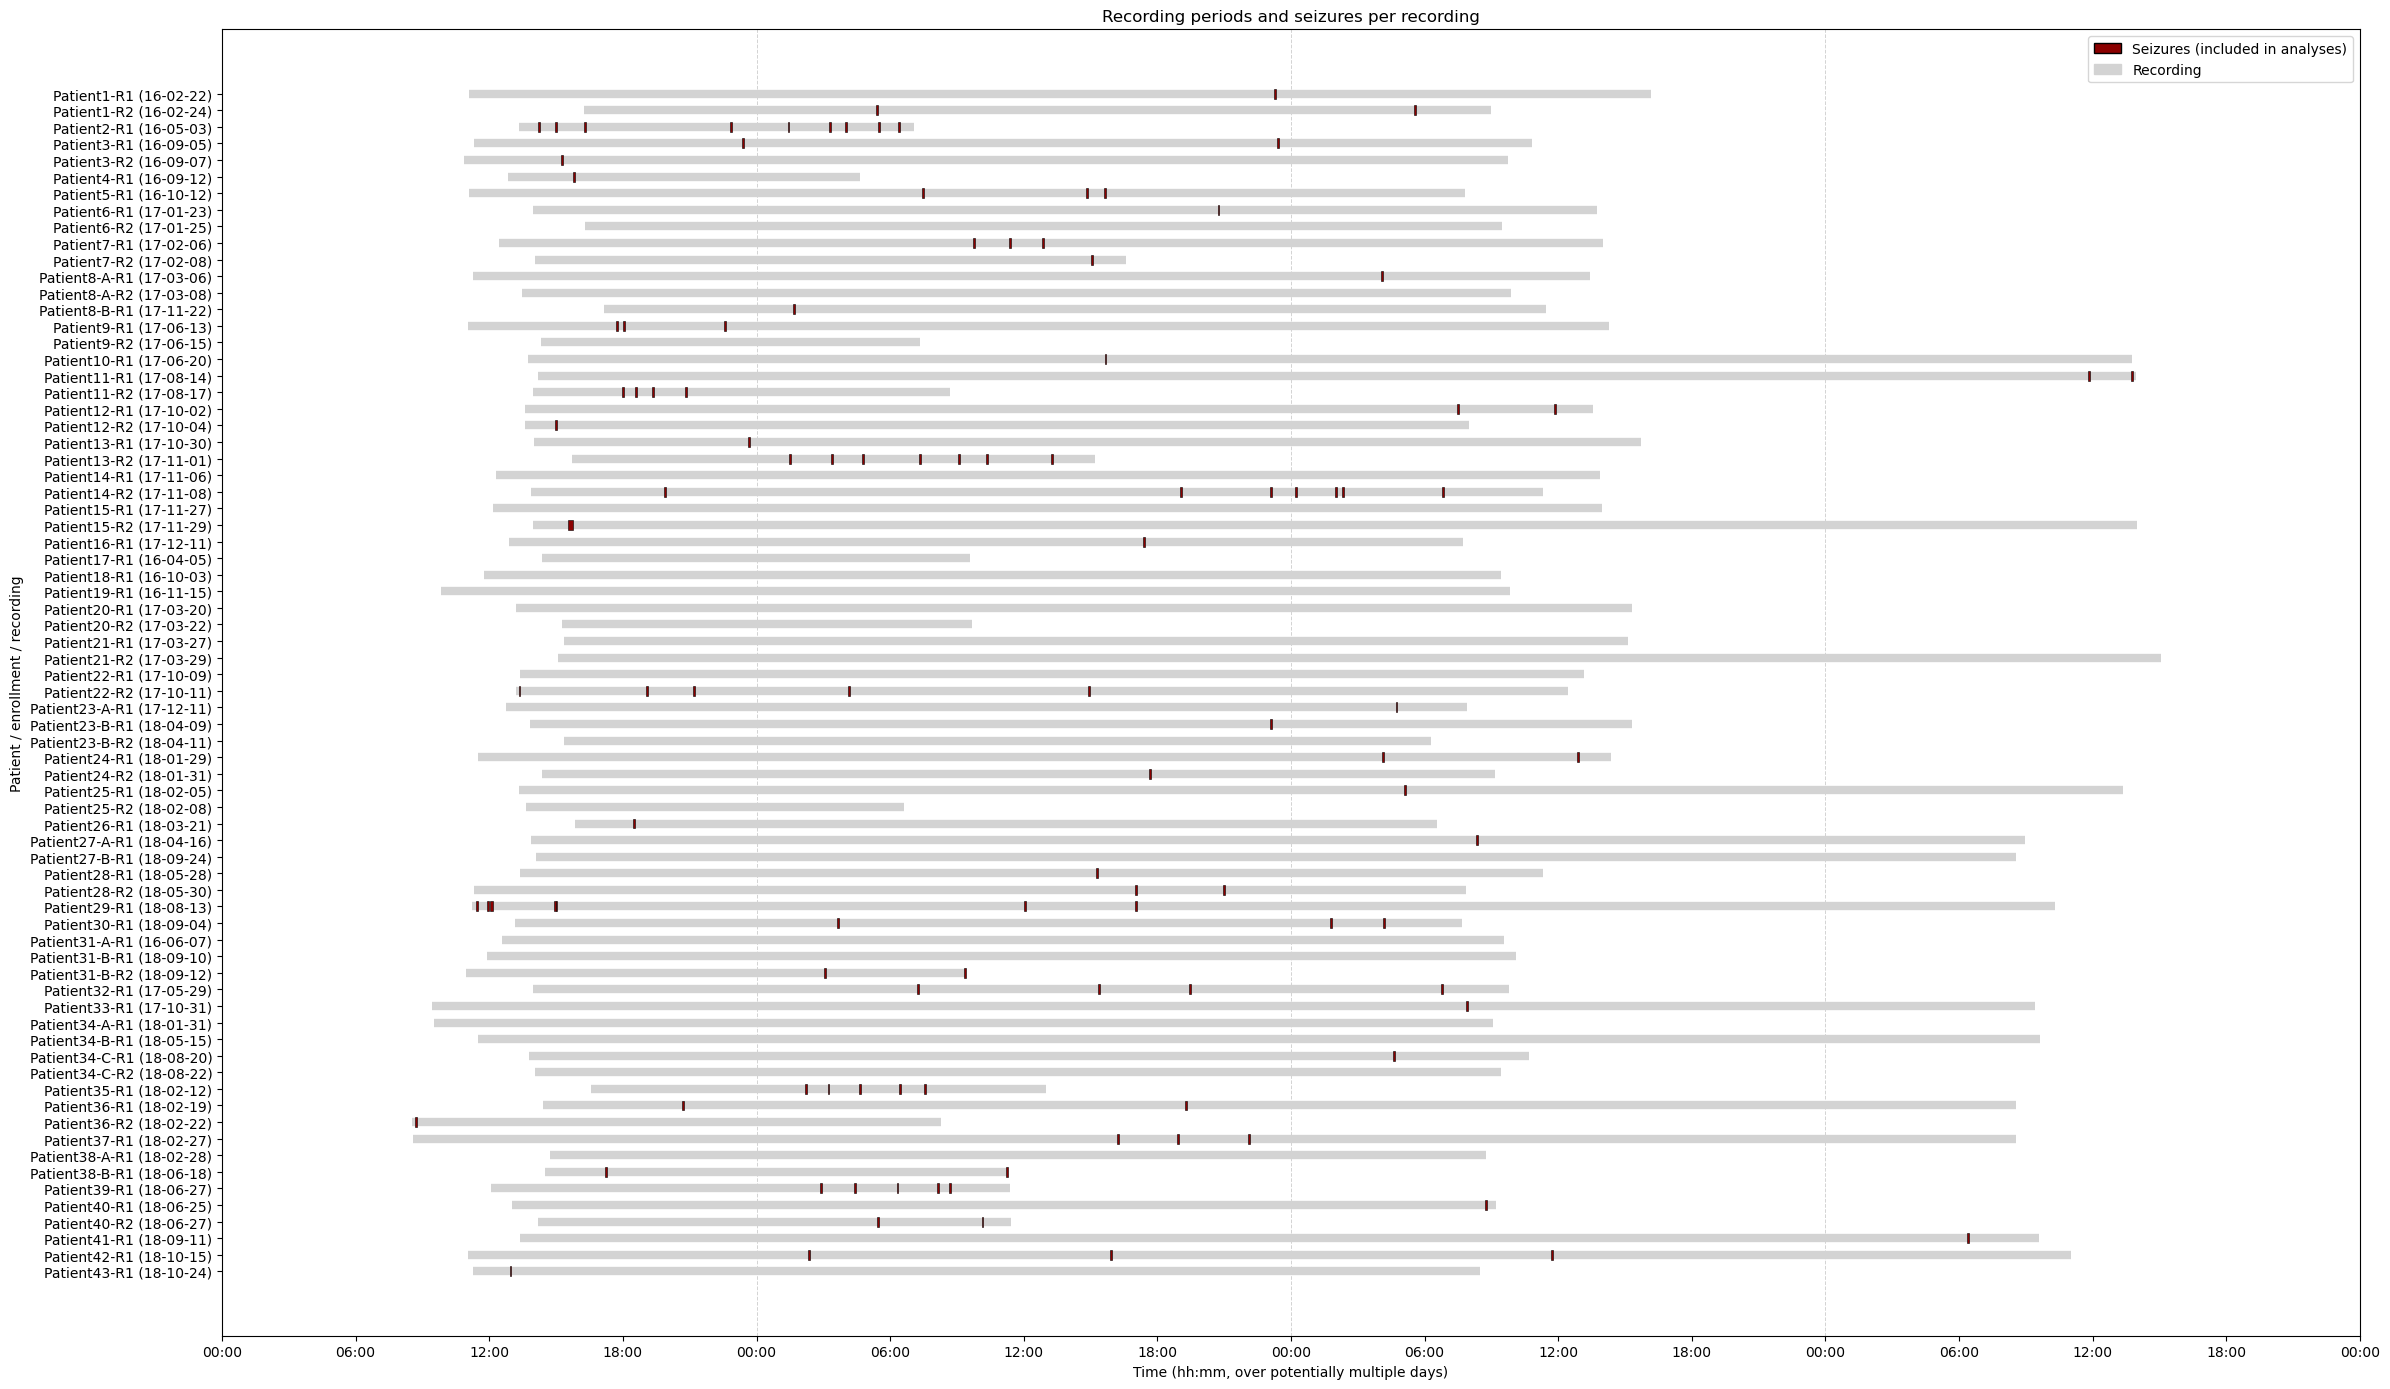

In [13]:
# Sort after patient/enrollment/recording:
recordings_sorted = sorted(
    recordings,
    key=lambda r: (r["patient_id"], r["enrollment_id"] or "", r["recording_id"])
)

plot_recording_seizure_timeline_multiday_clocklabels(
    recordings_sorted,
    max_hours=96.0,   # evt. sætte højere hvis nogle er meget lange
    day_grid=True,
)
